In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img

from keras import backend as K
import keras

from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

import threading
import pickle

In [ ]:
train_path = "dashcam/frames/training/positive"
test_path = "dashcam/frames/testing/positive"

frames_path = {}

train_data = []
test_data = []

In [ ]:
def make_sequences(frames, mode):
    
    frames = sorted(frames)
    sequences = []

    for i in range(0, 100, 25):
        sequence = frames[i:(i + 25)]
        if i < 75:
            label = np.zeros(25)
        else:
            label = np.concatenate((np.zeros(15), np.ones(10)), axis = 0)
        item = sequence, label
        if(mode == "train"):
            train_data.append(item)
        elif(mode == "test"):
            test_data.append(item)

In [ ]:
for category in ["train", "test"]:
    data_path = train_path if category == "train" else test_path
    
    for video in os.listdir(data_path):
        frames = []
        for frame in os.listdir(data_path + "/" + video):
            frames.append(video + "_" + frame)
            frames_path[video + "_" + frame] = data_path + "/" + video
        if len(frames) == 100:
            make_sequences(frames, category)

In [ ]:
def image_to_tensor(filename):
  
    tokens = filename.split("_")
    im = load_img(frames_path[filename] + "/frame_" + tokens[2], target_size = (256, 256))
    im = img_to_array(im)
    im =  im / 255.
    #plt.imshow(im.astype(np.uint8))

    return im

In [ ]:
def sequence_prep(sequence):
  
    x, y = sequence

    images = []

    for filename in x:
        im = image_to_tensor(filename)
        images.append(im)

    images = np.array(images)  # (25, 256, 256, 3)
    labels = np.reshape(y, (images.shape[0], 1))   # (25, 1)

    return images, labels

In [ ]:
def batch_prep(batch):
  
    batch_x = []
    batch_y = []

    for sequence in batch:
        images, labels = sequence_prep(sequence)
        batch_x.append(images)
        batch_y.append(labels)

    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)

    #print("(batch_size, no_of_frames, img_height, img_width, channels) = " + str(batch_x.shape))
    #print("(batch_size, no_of_frames, class_value) = " + str(batch_y.shape))

    return batch_x, batch_y

In [ ]:
class threadsafe_iterator:
    def __init__(self, iterator):
        self.iterator = iterator
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.iterator)

def threadsafe_generator(func):
    """Decorator"""
    def gen(*a, **kw):
        return threadsafe_iterator(func(*a, **kw))
    return gen

In [ ]:
@threadsafe_generator
def data_generator(mode):
    
    data = train_data if mode == "train" else test_data
    np.random.shuffle(data)
  
    batch_size = 10
    nb_batch = len(data) // batch_size
    
    print("Mode: " + mode + " => data generator in work to produce: " + str(nb_batch) + " batches from " + str(len(data)) + " data instances. ")

    while True:
        for i in range(nb_batch):

            beg = i * batch_size
            end = (i * batch_size + batch_size) if i * batch_size < len(data) else -1

            batch = data[beg : end]
            batch_x, batch_y = batch_prep(batch)
            
            batch_x_encoder = batch_x[:, :20, :, :, :]
            batch_x_decoder = batch_x[:, 19:24, :, :, :]
            batch_y_decoder = batch_y[:, 20:25, :]

            yield [batch_x_encoder, batch_x_decoder], [batch_y_decoder]
        
# for i in range(5):
#     for data in data_generator("test"):
#         x_batch, y_batch = data
#         print("x_batch.shape: " + str(x_batch.shape) + " y_batch.shape: " + str(y_batch.shape))


In [ ]:
shape = (256,256,3)
n_units = 512
resnet = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=shape, pooling="max")
resnet.trainable = False
for layer in resnet.layers:
    layer.trainable = False
inp = Input(shape)
f = resnet(inp)
f = Dense(n_units , activation='relu')(f)
resnet = Model(inputs = inp , outputs = f , name="resnet_f")

resnet.summary()

In [ ]:
def weighted_binary_crossentropy( y_true, y_pred, weight = 9.) :
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1)

In [ ]:
enc_time_step = 20
dec_time_step = 5

encoder = LSTM(n_units , return_sequences=True , return_state=True , name="encoder")
decoder = LSTM(n_units , return_sequences=True , return_state=True , name="decoder")
decoder_dense1 = Dense(32 , activation = "relu")
decoder_dense2 =  Dense(1 , activation =  "sigmoid")

encoder_input = Input((enc_time_step,)+shape)
cnn_features = TimeDistributed(resnet)(encoder_input)
encoder_outputs , state_h , state_c = encoder(cnn_features)
encoder_outputs = Dense(32 , activation = "relu")(Dropout(rate = 0.2)(encoder_outputs))
encoder_outputs = Dense(1 , activation =  "sigmoid")(Dropout(rate = 0.2)(encoder_outputs))
encoder_model = Model(inputs = encoder_input , outputs = [encoder_outputs , state_h , state_c])

decoder_input = Input((dec_time_step,)+shape)
cnn_features = TimeDistributed(resnet)(decoder_input)
decoder_outputs , _ , _ = decoder(cnn_features , initial_state=[state_h , state_c])
decoder_outputs = decoder_dense1(Dropout(rate = 0.2)(decoder_outputs))
decoder_outputs = decoder_dense2(Dropout(rate = 0.2)(decoder_outputs))

seq2seq_model = Model(inputs = [encoder_input,decoder_input] , outputs = [encoder_outputs,decoder_outputs])
seq2seq_model.summary()

optimizer = Adam(lr=1e-4)
metrics = ['accuracy']
seq2seq_model.compile(loss=[weighted_binary_crossentropy, weighted_binary_crossentropy], optimizer=optimizer, metrics=metrics)

In [ ]:
inp = Input((enc_time_step,)+shape)
features = TimeDistributed(resnet)(inp)
_ , state_h , state_c = encoder(features)

start_frame = Input((1,)+shape)
features = TimeDistributed(resnet)(start_frame)
pred = []

for i in range(dec_time_step):
    features , state_h , state_c = decoder(features , initial_state=[state_h , state_c])  # remove the inf infront , use the decoder layer already quoted above for the seq2seq model
    decoder_outputs = decoder_dense1(features) # same here
    decoder_outputs = decoder_dense2(decoder_outputs) # same here
    pred+=[decoder_outputs]

pred = Concatenate(axis = -2)(pred)
seq2seq_inference = Model(inputs=[inp , start_frame] , outputs = pred)
seq2seq_inference.summary()

In [ ]:
checkpoint = ModelCheckpoint(
        filepath=os.path.join('saved_models', 'seq2seq_accident_prediction_discarded', 'model_seq2seq_accident_prediction_discarded' + \
            '.{epoch:03d}-{loss:.3f}.hdf5'),
        verbose=1,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True)

train_datagen = data_generator("train")
test_datagen = data_generator("test")

history = seq2seq_model.fit_generator(generator = train_datagen, steps_per_epoch = 182, epochs = 40, verbose = 1, workers = 4, shuffle = False, callbacks = [checkpoint], validation_data = test_datagen, validation_steps = 60, initial_epoch = 0)

In [ ]:
pickle_out = open("saved_models/seq2seq_accident_prediction/history_seq2seq_accident_prediction_discarded_e40.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [ ]:
def model_inference(video_path): 
    
    file_idx = video_path.split("/")[-1]
    
    frame_names = []
    for frame in os.listdir(video_path):
        frame_names.append(frame)
    frame_names = sorted(frame_names)

    frames = []
    for frame in frame_names:
        img = load_img(video_path + "/" + frame, target_size = (256, 256))
        img = img_to_array(img)
        img =  img / 255.
        frames.append(img)
    frames = np.array(frames)

    seq2seq_model.load_weights("saved_models/seq2seq_accident_prediction_discarded/seq2seq_accident_prediction_discarded.036-0.801.hdf5")
    
    for i in range(0, 100, 25):
        predictions = []
        input_sequence1 = frames[i : i + 20]
        input_sequence1 = np.array([input_sequence1])
        input_sequence2 = frames[i + 19]
        input_sequence2 = np.array([[input_sequence2]])
        pred = seq2seq_inference.predict([input_sequence1, input_sequence2])
        pred = np.reshape(pred, (5, 1))      
        for i in pred:
            predictions.append(i[0])
        print(predictions)

#     plt.plot(range(100), predictions, '-b', label='validation activations')
#     plt.ylabel("Final activations")
#     plt.xlabel("Frames - " + file_idx)
#     plt.title("Accident Classifier - Inference")
#     plt.show()

In [ ]:
model_inference("dashcam/frames/testing/positive/000508")

In [21]:
pickle_in = open("saved_models/seq2seq_accident_prediction_discarded/history_seq2seq_accident_prediction_discarded_e10.pickle","rb")
loaded_history = pickle.load(pickle_in)

val_loss = loaded_history["val_loss"]
val_encoder_output_loss = loaded_history["val_encoder_output_loss"]
val_decoder_output_loss = loaded_history["val_decoder_output_loss"]
val_encoder_output_acc = loaded_history["val_encoder_output_acc"]
val_encoder_output_acc = loaded_history["val_encoder_output_acc"]
val_decoder_output_acc = loaded_history["val_decoder_output_acc"]

training_loss = loaded_history["loss"]
training_encoder_output_loss = loaded_history["encoder_output_loss"]
training_decoder_output_loss = loaded_history["decoder_output_loss"]
training_encoder_output_acc = loaded_history["encoder_output_acc"]
training_decoder_output_acc = loaded_history["decoder_output_acc"]

epochs = range(10)

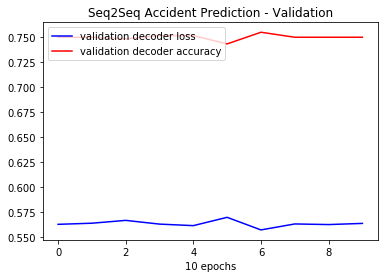

In [22]:
plt.plot(epochs, val_decoder_output_loss, '-b', label='validation decoder loss')
plt.plot(epochs, val_decoder_output_acc, '-r', label='validation decoder accuracy')

plt.xlabel("10 epochs")
plt.legend(loc='upper left')
plt.title("Seq2Seq Accident Prediction - Validation")

plt.savefig("figures/seq2seq_accident_prediction_discarded_e10_val" + ".png")  
plt.show()

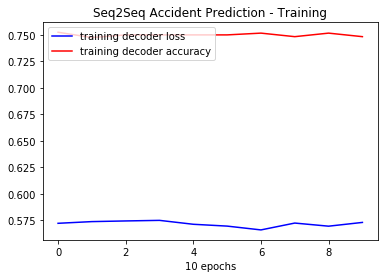

In [23]:
plt.plot(epochs, training_decoder_output_loss, '-b', label='training decoder loss')
plt.plot(epochs, training_decoder_output_acc, '-r', label='training decoder accuracy')

plt.xlabel("10 epochs")
plt.legend(loc='upper left')
plt.title("Seq2Seq Accident Prediction - Training")

plt.savefig("figures/seq2seq_accident_prediction_e20_train" + ".png")  
plt.show()